# Feature and model selection for heart disease predictions
## Loaded packages 

In [1]:
import pandas as pd
import numpy as np
from sklearn import (
    svm,
    preprocessing
)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import (
    SelectKBest,
    chi2
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sn
import matplotlib.pyplot as plt
import missingno as mno
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

## Data loaded

In [2]:
clevelandData = pd.read_csv("processed.cleveland.data", sep =",", header= None, na_values=["?"])
switzerlandData = pd.read_csv("processed.switzerland.data", sep= ",", header= None, na_values=["?"])
longbeachData = pd.read_csv("processed.va.data", sep = "," , header=None, na_values=["?"])
hungarianData = pd.read_csv("reprocessed.hungarian.data", sep = " " , header=None, na_values=["?"])
data = pd.concat([clevelandData, switzerlandData, longbeachData, hungarianData])
data.columns = ["age", "sex", "cp", "trestbps", "chol", "fbs" , "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "prediction"]

## Processing
### Dealing with missing predicted outcome

In [3]:
data = data.dropna(axis= 0, subset=["prediction"])
data.isnull().sum()/len(data)
data.dtypes

data[data<0].count()
## mno.matrix(data, figsize=(20,6))


age             0
sex             0
cp              0
trestbps        1
chol           23
fbs             8
restecg         1
thalach         1
exang           1
oldpeak        12
slope         190
ca            290
thal          266
prediction      0
dtype: int64

### Using simple imputerto fill the nan values in the rest of the dataset

In [4]:
nanImpute = SimpleImputer(missing_values=np.nan, strategy='mean')
dataval = nanImpute.fit_transform(data)

data = pd.DataFrame(dataval, columns=  ["age", "sex", "cp", "trestbps", "chol", "fbs" , "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "prediction"])

data[["age", "sex","cp", "restecg","thalach", "slope", "ca" , "thal"]] = data[["age", "sex","cp", "restecg","thalach", "slope", "ca" , "thal"]].astype(int)
data[["fbs", "exang"]] = data[["fbs", "exang"]].astype(bool)

### Standartizing data using MinMaxScaler

In [5]:
data[data<0].count()
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
dataToScale = data [["age", "sex", "cp", "trestbps", "chol", "restecg", "thalach", "oldpeak", "slope", "ca", "thal"]]
normalizedValues = scaler.fit_transform(dataToScale)
normalizedData = pd.DataFrame(normalizedValues, columns= dataToScale.columns)
normalizedData = normalizedData.join(data[["fbs", "exang","prediction"]])


## Feature selection
### Select k best

[5.942e+00 1.852e+01 2.674e+01 3.022e-01 4.628e+00 4.382e-02 3.017e+00
 6.934e+00 2.895e+01 4.083e+00 1.723e+01 3.844e+01 1.092e+02]


<Axes: >

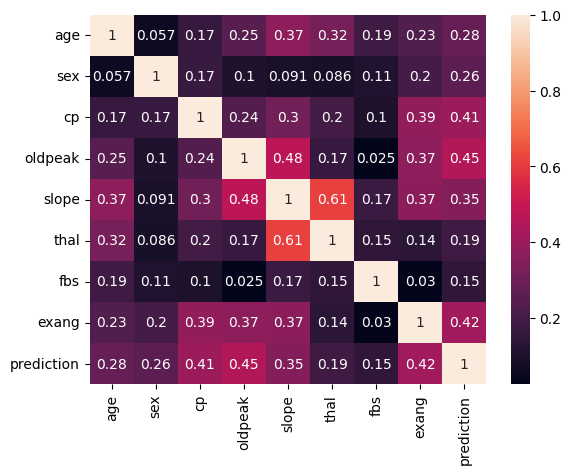

In [7]:
variables =  normalizedData.iloc[:,normalizedData.columns != "prediction"]
predictions = normalizedData["prediction"]  
selector = SelectKBest(chi2, k=8).fit(variables, predictions)

np.set_printoptions(precision=3)

print (selector.scores_)

bestKSelected = selector.get_support(indices=True)
selectedData = variables.iloc[:, bestKSelected]
predictions = predictions.to_frame()
selectedData = selectedData.join(predictions)

corrSelectedData = selectedData.corr()

sn.heatmap(corrSelectedData, annot= True)


### Recursive feature elimination

In [13]:
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(selectedData.loc[:,selectedData.columns!= "prediction"],selectedData["prediction"])


selectedColNames = fit.get_support(indices=True)
SelectedValues = selectedData.iloc[:, selectedColNames]


print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (SelectedValues.columns))
print("Feature Ranking: %s" % (fit.ranking_))


Num Features: 5
Selected Features: Index(['age', 'sex', 'cp', 'oldpeak', 'slope'], dtype='object')
Feature Ranking: [1 1 1 1 1 4 3 2]


## Train/test data separation

In [9]:
attributes = SelectedValues

X_train, X_test, Y_train, Y_test = train_test_split(attributes, predictions, test_size= 0.33, random_state=5 )




### Naive model

Accuracy: 0.4967105263157895
F1 Score: 0.5279510579186302


c:\Users\migli\source\repos\PyHeartDisease\.venv\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


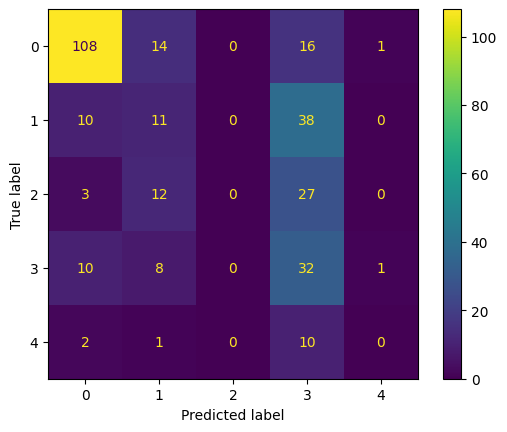

In [10]:
model = GaussianNB()

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, Y_test)
f1 = f1_score(y_pred, Y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

labels = [0,1,2,3,4]
cm = confusion_matrix(Y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();


### KNC model

c:\Users\migli\source\repos\PyHeartDisease\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.45394736842105265
F1 Score: 0.47969341161121976


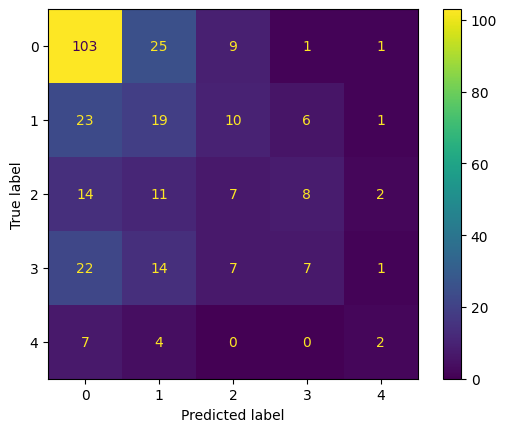

In [11]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)

y_pred = knn.predict(X_test)
f1 = f1_score(y_pred, Y_test, average="weighted")
accuray = accuracy_score(y_pred, Y_test)

print("Accuracy:", accuray)
print("F1 Score:", f1)

labels = [0,1,2,3,4]
cm = confusion_matrix(Y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();



### SVC model

c:\Users\migli\source\repos\PyHeartDisease\.venv\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\migli\source\repos\PyHeartDisease\.venv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.506578947368421
F1 Score: 0.5283492347105063


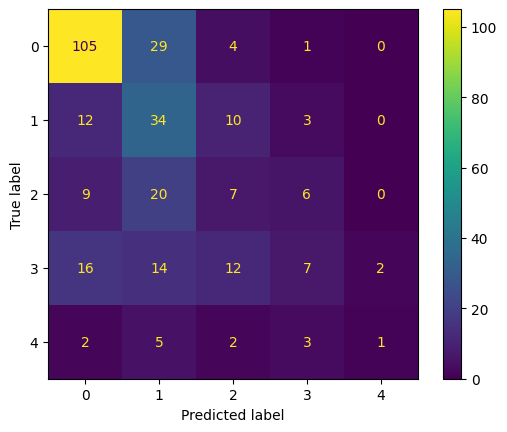

In [12]:
svm= svm.SVC(kernel='rbf', C= 100, gamma=2, max_iter=1000)
svm.fit(X_train, Y_train)

y_pred = svm.predict(X_test)
f1 = f1_score(y_pred, Y_test, average="weighted")
accuray = accuracy_score(y_pred, Y_test)

print("Accuracy:", accuray)
print("F1 Score:", f1)

labels = [0,1,2,3,4]
cm = confusion_matrix(Y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();
